In [10]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar -xvzf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

# findspark will locate spark in the system
import findspark
findspark.init()

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [742 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.2 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **PACKAGES AND IMPORTS**

In [11]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("local") \
        .appName("Hands-on PySpark on Google Colab") \
        .getOrCreate()
import pyspark
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
sqlContext = pyspark.SQLContext.getOrCreate(spark)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")        

df_business = sqlContext.read.json('drive/MyDrive/Big data/yelp_academic_dataset_business.json')
df_review = sqlContext.read.json('drive/MyDrive/Big data/yelp_academic_dataset_review.json')
#df_business = sqlContext.read.json('/content/drive/MyDrive/Big data/yelp_academic_dataset_business.json')
#df_review = sqlContext.read.json('/content/drive/MyDrive/Big data/yelp_academic_dataset_review.json')


#Edit - Yashika
#df_business = spark.read.json('/content/drive/MyDrive/YELP_DATASET/yelp_academic_dataset_business.json')
#df_review  = spark.read.json('/content/drive/MyDrive/YELP_DATASET/yelp_academic_dataset_review.json')
#df_user  = spark.read.json('/content/drive/MyDrive/YELP_DATASET/yelp_academic_dataset_user.json')

# **FILTERING FOR RESTAURANTS IN PHILADELPHIA**

In [12]:
df_business = df_business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "city","latitude","longitude").withColumnRenamed("stars", "stars_restaurant")
df_business = df_business.filter((col("city")=="Philadelphia") & col("categories").contains("Restaurants")).drop("city")
df_review = df_review.join(df_business, on='business_id', how='inner')
df_review_transform = df_review.select("user_id","business_id","stars")

# **PHASE 1: Data Exploration:**

Lets explore the following

1.   Ratings distribution from the patrons of Philadelphia
2.   Sparcity of the user-item interaction matrix
3.   Long Tail Plot
4.   Most active reviewers of the system
5.   The restaurants with most customer traffic
6.   Most valueable Patrons of a particular restaurant
7.   Categories of dishes that have the poorest of ratings in Philadelphia




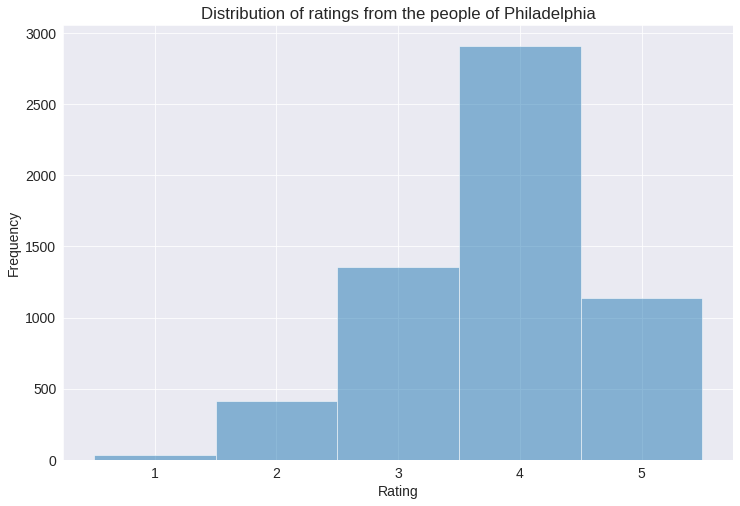

In [6]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
restaurant_reviews = df_business.select('stars_restaurant').collect()
restaurant_reviews_list = [restaurant_reviews[i][0] for i in range(len(restaurant_reviews))]


#plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
#         histtype='stepfilled', color='steelblue',
#         edgecolor='none')
plt.figure(figsize=(12,8))
plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5)
plt.title('Distribution of ratings from the people of Philadelphia')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

***Distribution of ratings from the people of Philedelphia. Approximately looks like a normal distribution with most of reviews in the range 3.5 to 4.5. Quite generous people and good restaurants in Philadelphia.***

In [7]:
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset
    count_nonzero = ratings.select("stars").count()

    # Count the number of distinct userIds and distinct movieIds
    total_elements = ratings.select("user_id").distinct().count() * ratings.select("business_id").distinct().count()

    # Divide the numerator by the denominator
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% sparse.")
    
get_mat_sparsity(df_review)

The ratings dataframe is  99.94% sparse.


In [4]:
!pip install recmetrics

     |████████████████████████████████| 793 kB 6.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 13.2 MB 42.6 MB/s 
     |████████████████████████████████| 11.2 MB 48.3 MB/s 
     |████████████████████████████████| 381 kB 75.7 MB/s 
     |████████████████████████████████| 930 kB 44.1 MB/s 
     |████████████████████████████████| 297 kB 42.1 MB/s 
     |████████████████████████████████| 207 kB 74.1 MB/s 
     |████████████████████████████████| 138 kB 73.5 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 231 kB 55.5 MB/s 
     |████████████████████████████████| 48 kB 4.3 MB/s 
     |████████████████████████████████| 63 kB 868 kB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
     |████████████████████████████████| 4.0 MB 29.8 MB/s 
     |████████████████████████████████| 130 kB 76.5 MB/s 
     |████████████████████████████████| 428 kB 15.3 MB/s 
  Created wheel for r

In [6]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 4.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
recmetrics 0.1.5 requires matplotlib<4.0.0,>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import pandas as pd
import json
with open('/content/drive/MyDrive/Big data/yelp_academic_dataset_review.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 

df = pd.DataFrame(data)
df1 = df.groupby('business_id').sample(frac=.1) 

# **Long Tail Plot**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


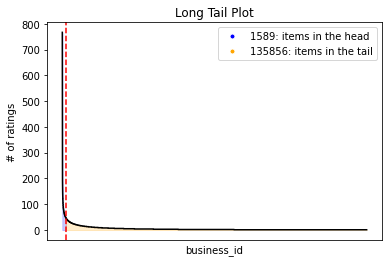

In [7]:
import recmetrics
recmetrics.long_tail_plot(df1,"business_id","ratings",0.2,x_labels=False)

***It can be seen that most of the review are for those 1% of most popular restaurants in the city, while others are just participants***

# **Identifying the most active reviewers of the system**

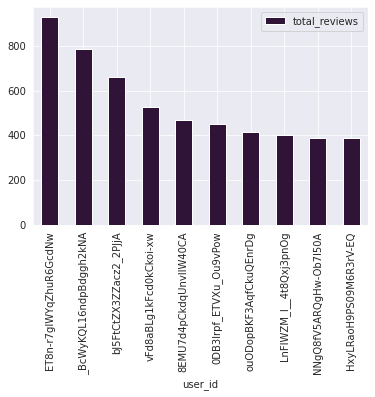

In [13]:
top_10_reviewers = df_review.select('name','user_id','review_id').groupby('user_id').agg(count('review_id')).withColumnRenamed("count(review_id)","total_reviews").orderBy(desc('total_reviews')).limit(10)
%matplotlib inline
plot_pd = top_10_reviewers.toPandas()
plot_pd.plot(kind='bar',x='user_id',y='total_reviews',colormap='twilight_shifted')

# **Finding out the restaurants with most customer traffic**

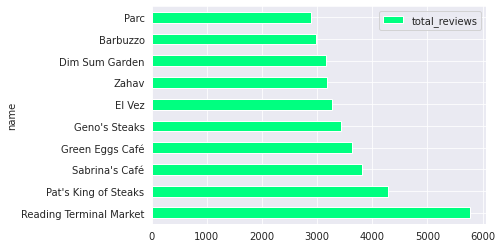

In [14]:
top_10_restaurants = df_review.select('name','user_id','review_id').groupby('name').agg(count('review_id')).withColumnRenamed("count(review_id)","total_reviews").orderBy(desc('total_reviews')).limit(10)
%matplotlib inline
plot_pd = top_10_restaurants.toPandas()
plot_pd.plot(kind='barh',x='name',y='total_reviews',colormap='winter_r')

# **Most valueable Patrons of restaurant with restaurant id AxcyIxsjJbRNG2RFTguavw**

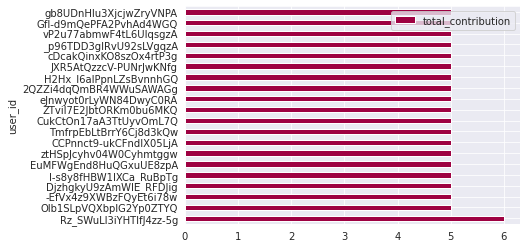

In [15]:
%matplotlib inline
mvp = df_review.where(col('business_id')=='AxcyIxsjJbRNG2RFTguavw').groupby('user_id').agg(sum('stars')).withColumnRenamed("sum(stars)","total_contribution").orderBy(desc("total_contribution")).limit(20)
plot_pd = mvp.toPandas()
plot_pd.plot(kind='barh',x='user_id',y='total_contribution',colormap='Spectral')

# **Categories of dishes that have the poorest of ratings in Philadelphia**

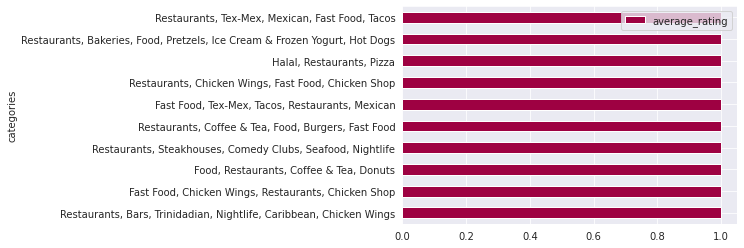

In [16]:
%matplotlib inline
poor_performers = df_business.groupby('categories').agg(mean('stars_restaurant')).withColumnRenamed("avg(stars_restaurant)","average_rating").orderBy("average_rating").limit(10)
plot_pd = poor_performers.toPandas()
plot_pd.plot(kind='barh',x='categories',y='average_rating',colormap='Spectral')

# **PHASE 2: Training the ALS model**

This phase involves the following steps

1.   Converting the userid and businessid which is of string type to unique integers using StringIndexer
2.   Splitting the dataset into training and testing
3.   Training the model and making predictions on the testing set
4.   Calculating the Root mean square error
5.   Making the recommendations for a given user



# **CONVERTING THE USERID AND BUSINESSID OF STRING TYPE TO UNIQUE INTEGERS**

In [17]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_review_transform).transform(df_review_transform)

# **SPLITTING THE DATASET INTO TRAINING AND TESTING**

In [18]:
(training, test) = transformed.randomSplit([0.8, 0.2],seed=200)
training.cache()
test.cache()

DataFrame[user_id: string, business_id: string, stars: double, business_id_index: double, user_id_index: double]

# **TRAINING THE ALS MODEL ON THE TRAINING DATASET AND PREDICTING THE VALUES FOR RATING ON THE TESTING DATASET**

In [19]:
als_best=ALS(maxIter=10,
        regParam=0.4,
        rank=20,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)
model_final=als_best.fit(training)
evaluator1=RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions=model_final.transform(test)
rmse_final=evaluator1.evaluate(predictions)


**THE ROOT MEAN SQUARE ERROR THAT INDICATES THE GOODNESS OF PREDICTION**

In [ ]:
print("RMSE="+str(rmse_final))

RMSE=1.249673673763062


# **CONSTRUCTING RECOMMENDATIONS FOR A USER WITH USERID mNCd6ctHcY0ueistbprTwg**

In [20]:
users = transformed.select(als_best.getUserCol()).distinct().limit(2)
userSubsetRecs = model_final.recommendForUserSubset(users, 10)

In [21]:
userSubsetRecs.show(truncate=False)

+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id_index|recommendations                                                                                                                                                                          |
+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|20593        |[{5510, 4.9350367}, {5740, 4.743883}, {5395, 4.6760054}, {3681, 4.6416554}, {5758, 4.6173882}, {4697, 4.5239224}, {5309, 4.49331}, {3352, 4.490027}, {4679, 4.489613}, {5401, 4.4851503}]|
+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
transformed.select("user_id").where(col('user_id_index')==20593).show(truncate=False)

+----------------------+
|user_id               |
+----------------------+
|mNCd6ctHcY0ueistbprTwg|
|mNCd6ctHcY0ueistbprTwg|
|mNCd6ctHcY0ueistbprTwg|
|mNCd6ctHcY0ueistbprTwg|
|mNCd6ctHcY0ueistbprTwg|
|mNCd6ctHcY0ueistbprTwg|
+----------------------+



In [38]:
userSubsetRecs.withColumn("recommendations",explode("recommendations")).show()

+-------------+-----------------+
|user_id_index|  recommendations|
+-------------+-----------------+
|        20593|{5510, 4.9350367}|
|        20593| {5740, 4.743883}|
|        20593|{5395, 4.6760054}|
|        20593|{3681, 4.6416554}|
|        20593|{5758, 4.6173882}|
|        20593|{4697, 4.5239224}|
|        20593|  {5309, 4.49331}|
|        20593| {3352, 4.490027}|
|        20593| {4679, 4.489613}|
|        20593|{5401, 4.4851503}|
+-------------+-----------------+



In [39]:
values =[[20593,5510, 4.9350367],[20593,5740, 4.743883],[20593,5395, 4.6760054],[20593,3681, 4.6416554],[20593,5758, 4.6173882],[20593,4697, 4.5239224],[20593,5309, 4.49331],[20593,3352, 4.490027],[20593,4679, 4.489613],[20593,5401, 4.4851503]]
columns = ['user_id','business_id','rating']
als_recommendations_df = spark.createDataFrame(values, columns)

In [49]:
recommended_restaurants = als_recommendations_df.join(transformed,(transformed.business_id_index == als_recommendations_df.business_id)).select(transformed.business_id).distinct().orderBy(desc(als_recommendations_df.rating))

In [52]:
recommended_restaurants.join(df_business,recommended_restaurants.business_id == df_business.business_id).select(df_business.business_id,df_business.name).show()

+--------------------+--------------------+
|         business_id|                name|
+--------------------+--------------------+
|PBjjuAkc9QX2UWMc3...|  Fiorella's Sausage|
|xWCERoeAakW3OiA4D...|         Pat's Place|
|qD5_El9SoKo0qJCdg...|       Crescent City|
|AxcyIxsjJbRNG2RFT...| Mike's Hot Dog Cart|
|LI-ajMokOWZpefMUA...|           Cafe Binh|
|sklR_i9tYQZEcfpRj...|Lakeside Chinese ...|
|Rta-rDiQ37MsWGPsC...|         Cafe Mai Vy|
|SDYbtInZIV9dpf7F9...|   The Chilly Banana|
|5ISqvo9dxmFY6MkXF...|       Non Stop Gyro|
|XG5-bigWGG_IFgbCv...|    Mubarak Shawarma|
+--------------------+--------------------+



# **THE TABLE CONTAINING THE PREDICTIONS MADE FOR ALL USERS, BUSINESS COMBINATION IN THE TEST SET**

In [ ]:
predictions.show()

+--------------------+--------------------+-----+-----------------+-------------+----------+
|             user_id|         business_id|stars|business_id_index|user_id_index|prediction|
+--------------------+--------------------+-----+-----------------+-------------+----------+
|lhfbA4aEcRGdKyci6...|jS3affmkXWrBnidXA...|  4.0|            148.0|       1395.0| 3.7633114|
|P_-_24R8kdvhWWadD...|jS3affmkXWrBnidXA...|  5.0|            148.0|      23607.0| 4.0451136|
|fzZimChayZDz1ISU6...|jS3affmkXWrBnidXA...|  5.0|            148.0|       2572.0| 3.4801888|
|fcTpx0gsSyYV6AXvg...|jS3affmkXWrBnidXA...|  5.0|            148.0|      32786.0|  4.075442|
|zoS5f0JWThXQnpkxz...|jS3affmkXWrBnidXA...|  5.0|            148.0|       1157.0| 4.0241413|
|mswloq-IjRr9yXLhB...|jS3affmkXWrBnidXA...|  4.0|            148.0|        133.0|  3.375725|
|vEFJfeis4LEuM-y4q...|jS3affmkXWrBnidXA...|  4.0|            148.0|       1133.0| 3.6657314|
|d6LlxfJxQXwpYgOKF...|jS3affmkXWrBnidXA...|  5.0|            148.0|   

# **IN AN ATTEMPT TO BUILD A HYBRID RECOMMENDATION, RECOMMENDING THE SAME USER USING COSINE SIMILARITY**

In [53]:
##################Cosine Similarity#########################
df_user = sqlContext.read.json('drive/MyDrive/Big data/yelp_academic_dataset_user.json')
df_review_PA = df_review.join(df_business, on = 'business_id', how = 'inner') \
                          .select(df_review.business_id, df_review.user_id, df_review.review_id, df_review.stars, df_review.text)
df_review_PA.show(2)

df_review_count = df_review_PA.count()
print(f'Business Reviews count: {df_review_count}')
# Extract PA user data
# Similary, filter all those users who have given reviews or ratings to restaurants extracted in above step.
df_user_PA = df_user.join(df_review_PA, on = 'user_id', how = 'inner') \
                          .select(df_user.user_id, df_user.name, df_user.review_count, df_user.yelping_since, \
                                  df_user.useful, df_user.funny , df_user.cool , df_user.fans , df_user.average_stars)
df_user_PA.show(2)
df_user_PA_count = df_user_PA.count()
print(f'User Reviews count: {df_user_PA_count}')

+--------------------+--------------------+--------------------+-----+--------------------+
|         business_id|             user_id|           review_id|stars|                text|
+--------------------+--------------------+--------------------+-----+--------------------+
|kxX2SOes4o-D3ZQBk...|_7bHUi9Uuf5__HHc_...|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|
|04UD14gamNjLY0IDY...|eUta8W_HdHMXPzLBB...|JrIxlS1TzJ-iCu79u...|  1.0|I am a long term ...|
+--------------------+--------------------+--------------------+-----+--------------------+
only showing top 2 rows

Business Reviews count: 687289
+--------------------+-------------+------------+-------------------+------+-----+----+----+-------------+
|             user_id|         name|review_count|      yelping_since|useful|funny|cool|fans|average_stars|
+--------------------+-------------+------------+-------------------+------+-----+----+----+-------------+
|--UhENQdbuWEh0mU5...|        Sonny|           1|2017-06-19 18:37:56|  

In [54]:
# Store smaller datasets for further use

df_business.coalesce(1).write.parquet('/content/drive/MyDrive/YELP_DATASET/Small_Datasets/small_business')
df_review_PA.coalesce(1).write.parquet('/content/drive/MyDrive/YELP_DATASET/Small_Datasets/small_reviews')
df_user_PA.coalesce(1).write.parquet('/content/drive/MyDrive/YELP_DATASET/Small_Datasets/small_users')

In [55]:
# Read data generated from above process
business_df = spark.read.parquet('/content/drive/MyDrive/YELP_DATASET/Small_Datasets/small_business')
business_count = business_df.count()

review_df = spark.read.parquet('/content/drive/MyDrive/YELP_DATASET/Small_Datasets/small_reviews')
review_count = review_df.count()

user_df = spark.read.parquet('/content/drive/MyDrive/YELP_DATASET/Small_Datasets/small_users')
user_count = user_df.count()

print(f'Business Count: {business_count}')
print(f'Reviews Count: {review_count}')
print(f'Users Count: {user_count}')

Business Count: 5852
Reviews Count: 687289
Users Count: 687289


In [56]:
# Create review text df from reviews data
reviews_text = review_df.select('business_id', 'text')
#reviews_text.show(3)
# Group all reviews per business
from operator import add

reviews_by_business = reviews_text.rdd.map(tuple).reduceByKey(add)
columns = ['business_id', 'text']
reviews_by_business_df = spark.createDataFrame(reviews_by_business, schema = columns)
reviews_by_business_df.show(3)

# count should be the total number of business
reviews_by_business_df.count()

+--------------------+--------------------+
|         business_id|                text|
+--------------------+--------------------+
|kxX2SOes4o-D3ZQBk...|Wow!  Yummy, diff...|
|04UD14gamNjLY0IDY...|I am a long term ...|
|eFvzHawVJofxSnD7T...|My absolute favor...|
+--------------------+--------------------+
only showing top 3 rows



5852

In [57]:
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.feature import StopWordsRemover, VectorAssembler
from pyspark.ml.feature import IDF
from pyspark.ml import Pipeline, PipelineModel
# Now, we will do the text processing
# Remove the stop words from text, and create the tf idf matrix 
# Will build a pipeline for this task

tokenizer        = RegexTokenizer(pattern = '\w+', inputCol = 'text', outputCol = 'tokens', toLowercase=True, gaps = False)
stopWordsRemover = StopWordsRemover(inputCol = 'tokens', outputCol = 'nostopwords')
countVectorizer  = CountVectorizer(inputCol='nostopwords', outputCol='tf', vocabSize=1000)
tfiDF            = IDF(inputCol='tf', outputCol='tfidf_vec')
pipeline         = Pipeline(stages=[tokenizer, stopWordsRemover, countVectorizer, tfiDF])


# Fit the model
pipeline_model = pipeline.fit(reviews_by_business_df)
# save the pipeline model
pipeline_model.write().overwrite().save('pipeline_model')
# Load the pipeline model
pipeline_model = PipelineModel.load('pipeline_model')
# convert the review data into feature vectors
transformed_reviews_by_business = pipeline_model.transform(reviews_by_business_df)

In [58]:
import numpy as np
def cosineSimilarity(vector1, vector2):
    '''
    Function to compute cosine similarity between 2 vectors
    -------------------------------------------------------
    Input: 
        Vector-1: Each restaurants feature vector 
        Vector-2: myRestaurant Feature vector 
                  for which recommendations to be made
    
    Returns: A similarity score (between 0 and 1)
    '''
        
    #  sum(A . B) / (sqrt(sum (A**2)  * sqrt(sum (B**2)))
    numerator = np.dot(vector1, vector2)
    denominator = np.sqrt(np.dot(vector1, vector1)) * np.sqrt(np.dot(vector2, vector2))
    
    return float(numerator/denominator)

In [59]:
def getRestaurantDetails(sim_rest):
    '''
    Function to get the recommended restaurant details based on ids.
    ---------------------------------------------------------------
    Returns -> Name of restaurant
               Category of restaurant
               Rating
               Similarity score with input restaurant id
               Total review count given to that restaurant
    '''
    
    restaurant_details = sim_rest.join(business_df, on='business_id', how = 'inner') \
                                 .select(sim_rest.business_id, \
                                       sim_rest.similarity_score, business_df.name, \
                                       business_df.categories, business_df.stars_restaurant, business_df.review_count,
                                       business_df.latitude, business_df.longitude)
    
    return restaurant_details

In [60]:
# Selecting a random user 
from pyspark.sql.functions import rand
from pyspark.sql.functions import *
from pyspark.sql.types import *

#usr_id = review_df.select('user_id').orderBy(rand()).limit(1).collect()
my_user = 'mNCd6ctHcY0ueistbprTwg'#[val.user_id for val in usr_id][0]
user_reviews = review_df.filter( (review_df.user_id == my_user) & (review_df.stars > float(2.0)) )\
                        .select(review_df.business_id).distinct()
user_reviews.count()
#r-wMHBg1eWdPnxmnEkAPUQ - 2
#vZWT0pyH4vhrQUzo7MO3FA - 4
#AEijotPmJL2jYDK0gh_3UA - 12
#rX1ZGXDTi57s8OZsv8DE6Q - 

2

In [61]:
user_restaurants = [val.business_id for val in user_reviews.collect()]

user_rest_details = user_reviews.join(business_df, on='business_id', how = 'inner')

print(f'\nRestaurants previously reviewed by user: {my_user}')
user_rest_details.show()
user_rest_details.select('business_id', 'name', 'categories', 'stars_restaurant').orderBy('stars_restaurant', ascending=False).show()


def getUserRecommendations(restaurant_ids, all_business_tfidf) :
    '''
    Function to recommend restaurants based on
    cosine similarity score between user reviewed restaurant and others.
    ----------------------------------------------------------------
    Input:  IDs of max 5 restaurants for which recoemmendation is needed
    Return: A dataframe with 5 recommendations for each of user reviews restaurants. 

    '''
    
    # Creating a dataframe to merge results of different input restaurant ids
    schema = StructType([   
                            StructField("business_id", StringType(), True)
                            ,StructField("similarity_score", IntegerType(), True)
                        ])

    similar_restuarants_final = spark.createDataFrame([], schema)


    for rest_id in user_restaurants:

        # Collecting feature values i.e. review texts for user rated restaurants
        user_restaurant_features = all_business_tfidf.map(lambda x: x[1] if x[0] == rest_id else None) \
                                                               .filter(lambda x: x != None).collect()[0]

        # Computing similarity between user rated restaurants and other restaurants reviews
        similar_restaurants_rdd = all_business_tfidf.map(lambda x: (x[0], cosineSimilarity(x[1], user_restaurant_features)))

        # Convert the results into df
        similar_restaurants_df = similar_restaurants_rdd.toDF(schema = ['business_id', 'similarity_score'])

        # Filter out those restaurants from this which are already been rated by our user
        similar_restaurants_df = similar_restaurants_df.filter(similar_restaurants_df.business_id != rest_id)

        similar_restaurants_df = similar_restaurants_df.orderBy('similarity_score', ascending=False).limit(5)


        similar_restuarants_final = similar_restuarants_final.union(similar_restaurants_df)

    # Data might contain duplicate restaurant ids, so removing those
    finalish = similar_restuarants_final.join(user_reviews, review_df['business_id']!=similar_restuarants_final['business_id'],'inner')
    finalish.dropDuplicates(['business_id']).orderBy('similarity_score', ascending=False).limit(10)
    
    return similar_restuarants_final


'''
Now, for making the recommendations
We will first fetch the feature values for all the restaurant ids 
and then find the similarity of our user's rated restaurants feature values with the rest ones 
'''

# Fetch all business word vectors -> (business_id => [reviews word vectors] ) 
all_business_tfidf = transformed_reviews_by_business.select('business_id', 'tfidf_vec') \
                                                    .rdd.map(lambda x: (x[0], x[1]))

# Get recommendations for user based on his reviews ones
similar_restuarants = getUserRecommendations(user_restaurants, all_business_tfidf)


# Get restaurant details for our similar df like name, categories, ratings and review count    
similar_restuarants_details = getRestaurantDetails(similar_restuarants)


print(f'\nRestaurants recommended for User: {my_user}')
#similar_restuarants_details.drop('latitude', 'longitude') \
similar_restuarants_details.orderBy('similarity_score', ascending=False).show(10)


Restaurants previously reviewed by user: mNCd6ctHcY0ueistbprTwg
+--------------------+-----------+----------------+------------+--------------------+--------------------+----------+-----------+
|         business_id|       name|stars_restaurant|review_count|          attributes|          categories|  latitude|  longitude|
+--------------------+-----------+----------------+------------+--------------------+--------------------+----------+-----------+
|CxXYiJBkq9kqsgtda...|      Bacio|             4.0|         183|{null, null, 'non...|Restaurants, Ital...|40.0541409|-75.1944474|
|OHplb2m_dKPXY46mS...|Stella Sera|             4.0|          48|{null, null, u'no...|Italian, Restaurants|40.0770647|-75.2087089|
+--------------------+-----------+----------------+------------+--------------------+--------------------+----------+-----------+

+--------------------+-----------+--------------------+----------------+
|         business_id|       name|          categories|stars_restaurant|
+-------

In [ ]:
userSubsetRecs.printSchema()

root
 |-- user_id_index: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- business_id_index: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
from pyspark.sql.functions import when
predictions = predictions.withColumn('user_affinity',when(predictions.stars>=3.50,1).otherwise(0))
predictions = predictions.withColumn('user_affinity_predicted',when(predictions.prediction>=3.50,1).otherwise(0))


In [ ]:
predictions.show()

+--------------------+--------------------+-----+-----------------+-------------+----------+-------------+-----------------------+
|             user_id|         business_id|stars|business_id_index|user_id_index|prediction|user_affinity|user_affinity_predicted|
+--------------------+--------------------+-----+-----------------+-------------+----------+-------------+-----------------------+
|lhfbA4aEcRGdKyci6...|jS3affmkXWrBnidXA...|  4.0|            148.0|       1395.0| 3.7445843|            1|                      1|
|P_-_24R8kdvhWWadD...|jS3affmkXWrBnidXA...|  5.0|            148.0|      23607.0|  4.012929|            1|                      1|
|fzZimChayZDz1ISU6...|jS3affmkXWrBnidXA...|  5.0|            148.0|       2572.0|  3.449664|            1|                      0|
|fcTpx0gsSyYV6AXvg...|jS3affmkXWrBnidXA...|  5.0|            148.0|      32786.0| 4.0339026|            1|                      1|
|zoS5f0JWThXQnpkxz...|jS3affmkXWrBnidXA...|  5.0|            148.0|       1157.0| 4

In [ ]:
userSubsetRecs.coalesce(1).write.json('predictionsforsingleuser1.json')

In [ ]:
predictions.coalesce(1).write.csv('overallpredictions1.csv')

In [ ]:
false_predictions = predictions.where(col('user_affinity')!=col('user_affinity_predicted')).count()

# **PHASE 3: Evaluating the performance of the algorithm**


1.   Calculate the general accuracy
2.   Choosing the best k using Precion,Recall and F score @K
3.   Plotting the ROC and AUC Curve
4.   Hyperparameter tuning trends w.r.t RMSE



# **Calculating the accuracy of our predictions**

In [ ]:
accuracy = (1 - (false_predictions/total_predictions))*100

In [ ]:
print(accuracy)

63.25721506006445


In [ ]:
total_train_positive = training.where(col('stars')>3.5).count()

In [ ]:
total_train = training.count()

In [ ]:
percent_positive = (total_train_positive/total_train)*100

# **The percentage of "positive reviews" in the training dataset is around 69%. Signs of skewedness**

In [ ]:
print(percent_positive)

68.5821490020334


# **Since the training data is skewed towards Positive reviews, the model could be biased towards positive labels and so accuracy is not a good measure. Hence precision and recall come into the picture.**

In [ ]:
true_positive = predictions.where((col('user_affinity')==1) & (col('user_affinity_predicted')==1)).count()

In [ ]:
false_positive = predictions.where((col('user_affinity')==0) & (col('user_affinity_predicted')==1)).count()

In [ ]:
print("The number of true positives is: " + str(true_positive))
print("The number of false positives is: " + str(false_positive))
precision = (true_positive)/(true_positive+false_positive)
false_negative = predictions.where((col('user_affinity')==1) & (col('user_affinity_predicted')==0)).count()
print("The number of false negatives is: " + str(false_negative))
recall = (true_positive)/(true_positive+false_negative)
print("The precision is: "+str(precision))
print("The recall is: "+str(recall))

The number of true positives is: 44347
The number of false positives is: 8743
The number of false negatives is: 31386
The precision is: 0.8353173855716708
The recall is: 0.5855703590244675


In [ ]:
predictions_for_plot = predictions

In [ ]:
predictions_for_plot.show()

+--------------------+--------------------+-----+-----------------+-------------+----------+
|             user_id|         business_id|stars|business_id_index|user_id_index|prediction|
+--------------------+--------------------+-----+-----------------+-------------+----------+
|lhfbA4aEcRGdKyci6...|jS3affmkXWrBnidXA...|  4.0|            148.0|       1395.0| 3.7525206|
|P_-_24R8kdvhWWadD...|jS3affmkXWrBnidXA...|  5.0|            148.0|      23607.0|  4.036782|
|fzZimChayZDz1ISU6...|jS3affmkXWrBnidXA...|  5.0|            148.0|       2572.0|  3.432745|
|fcTpx0gsSyYV6AXvg...|jS3affmkXWrBnidXA...|  5.0|            148.0|      32786.0|  4.088791|
|zoS5f0JWThXQnpkxz...|jS3affmkXWrBnidXA...|  5.0|            148.0|       1157.0| 4.0094576|
|mswloq-IjRr9yXLhB...|jS3affmkXWrBnidXA...|  4.0|            148.0|        133.0|  3.374188|
|vEFJfeis4LEuM-y4q...|jS3affmkXWrBnidXA...|  4.0|            148.0|       1133.0| 3.6611848|
|d6LlxfJxQXwpYgOKF...|jS3affmkXWrBnidXA...|  5.0|            148.0|   

In [ ]:
import numpy as np
precision_list =[]
recall_list=[]
f05_score_list = []
def calculate_prf(threshold_passed):
  true_positive = predictions_for_plot.where((col('user_affinity')==1) & (col('user_affinity_predicted')==1)).count()
  false_positive = predictions_for_plot.where((col('user_affinity')==0) & (col('user_affinity_predicted')==1)).count()
  #print("The number of true positives is: " + str(true_positive))
  #print("The number of false positives is: " + str(false_positive))
  if (true_positive+false_positive)>0:
      precision = (true_positive)/(true_positive+false_positive)
      
  else:
    precision =0    
  #print("The number of false negatives is: " + str(false_negative))
  false_negative = predictions_for_plot.where((col('user_affinity')==1) & (col('user_affinity_predicted')==0)).count()
  if (true_positive+false_negative)>0:
         recall = (true_positive)/(true_positive+false_negative)
  else:
    recall=0 
  if precision==0 and recall==0:        
    f05_score = 0     
  else: 
    f05_score = (1.25*precision*recall)/((0.25*precision)+recall)      
  #print("The precision is: "+str(precision))
  #print("The recall is: "+str(recall))
  precision_list.append(precision)
  recall_list.append(recall)
  f05_score_list.append(f05_score)
for threshold in np.arange(0, 5.5, 0.5):
  #predictions_for_plot = predictions_for_plot.withColumn('user_affinity',when(predictions.stars>=threshold,1).otherwise(0))
  predictions_for_plot = predictions_for_plot.withColumn('user_affinity_predicted',when(col('user_predictions')>threshold,1).otherwise(0))
  calculate_prf(threshold)
  predictions_for_plot = predictions_for_plot.drop('user_affinity_predicted')
print(precision_list)  
print(recall_list)
print(f05_score_list)



[0.6934240404336361, 0.6937601348565775, 0.6988072220509803, 0.7028628117913832, 0.711204005249599, 0.7312763958159082, 0.772185172564864, 0.834550198014227, 0.8860263618766706, 0.9238741285095158, 0]
[1.0, 0.9999075700157131, 0.9878784677749461, 0.9822798515838538, 0.9659989700658894, 0.9351141510305944, 0.837838194710364, 0.5871152601904057, 0.2538523497022434, 0.06474060185124055, 0.0]
[0.7387187205543536, 0.7390137505001514, 0.7422461739325406, 0.7452619050958439, 0.7508112801292302, 0.7646106174625625, 0.7844795398854165, 0.7696755051947557, 0.5914474696200583, 0.2528336135147121, 0]


# **The precision, recall and F0.5 score tradeoff with respect to various threshold values**

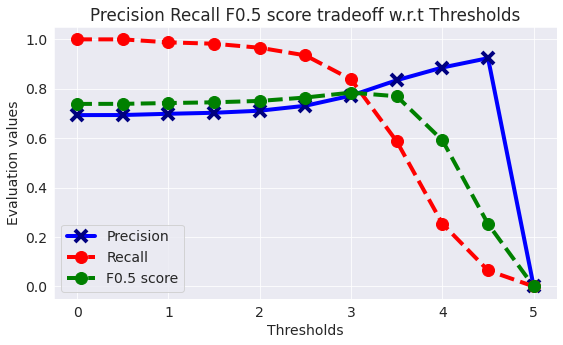

In [ ]:
import seaborn as sns
import matplotlib
thresholds = [0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
plt.plot(thresholds, precision_list, 'b-x', linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy')

# Second line
plt.plot(thresholds, recall_list, 'r--o', linewidth=4, markersize=12);
plt.plot(thresholds, f05_score_list, 'go--', linewidth=4, markersize=12);
# Title
plt.title('Precision Recall F0.5 score tradeoff w.r.t Thresholds')

# Line labels
plt.legend(['Precision', 'Recall','F0.5 score'])

# Axis labels
plt.xlabel('Thresholds'); plt.ylabel('Evaluation values');

# **It can be seen that at a Threshold value of 3.5 there exists the highest point in the precision, recall, F0.5 score combination**

In [ ]:
import numpy as np
tpr_list =[]
fpr_list=[]
def calculate_roc(threshold_passed):
  true_positive = predictions_for_plot.where((col('user_affinity')==1) & (col('user_affinity_predicted')==1)).count()
  false_positive = predictions_for_plot.where((col('user_affinity')==0) & (col('user_affinity_predicted')==1)).count()
  #print("The number of true positives is: " + str(true_positive))
  #print("The number of false positives is: " + str(false_positive))
  false_negative = predictions_for_plot.where((col('user_affinity')==1) & (col('user_affinity_predicted')==0)).count()
  true_negative = predictions_for_plot.where((col('user_affinity')==0) & (col('user_affinity_predicted')==0)).count()
  #print("The number of false negatives is: " + str(false_negative))
  #print("The number of true negatives is: " + str(true_negative))
  tpr = (true_positive)/(true_positive+false_negative)
  fpr = (false_positive)/(false_positive+true_negative)
  
  #print("The number of false negatives is: " + str(false_negative))
  #print("The precision is: "+str(precision))
  #print("The recall is: "+str(recall))
  tpr_list.append(tpr)
  fpr_list.append(fpr)
for threshold in np.arange(0, 5.5, 0.5):
  predictions_for_plot = predictions_for_plot.withColumn('user_affinity_predicted',when(predictions.prediction>threshold,1).otherwise(0))
  calculate_roc(threshold)
  predictions_for_plot = predictions_for_plot.drop('user_affinity_predicted')
print(tpr_list)
print(fpr_list)  

[1.0, 0.9999075700157131, 0.9878784677749461, 0.9822798515838538, 0.9659989700658894, 0.9351141510305944, 0.837838194710364, 0.5871152601904057, 0.2538523497022434, 0.06474060185124055, 0.0047403377655711515]
[1.0, 0.9983275094824239, 0.9630558791028283, 0.9392527551294687, 0.8872263536720126, 0.7772302362392856, 0.559089687304005, 0.26326792700773527, 0.07385837589224382, 0.012065824448227458, 0.0009557088671863334]


In [ ]:
predictions_for_plot = predictions_for_plot.drop('user_affinity').drop('user_affinity_predicted')
predictions_for_plot = predictions_for_plot.withColumn('user_affinity',when(predictions.stars>3.5,1).otherwise(0))
predictions_for_plot.show()

+--------------------+--------------------+-----+-----------------+-------------+----------+-------------+
|             user_id|         business_id|stars|business_id_index|user_id_index|prediction|user_affinity|
+--------------------+--------------------+-----+-----------------+-------------+----------+-------------+
|lhfbA4aEcRGdKyci6...|jS3affmkXWrBnidXA...|  4.0|            148.0|       1395.0| 3.7525206|            1|
|P_-_24R8kdvhWWadD...|jS3affmkXWrBnidXA...|  5.0|            148.0|      23607.0|  4.036782|            1|
|fzZimChayZDz1ISU6...|jS3affmkXWrBnidXA...|  5.0|            148.0|       2572.0|  3.432745|            1|
|fcTpx0gsSyYV6AXvg...|jS3affmkXWrBnidXA...|  5.0|            148.0|      32786.0|  4.088791|            1|
|zoS5f0JWThXQnpkxz...|jS3affmkXWrBnidXA...|  5.0|            148.0|       1157.0| 4.0094576|            1|
|mswloq-IjRr9yXLhB...|jS3affmkXWrBnidXA...|  4.0|            148.0|        133.0|  3.374188|            1|
|vEFJfeis4LEuM-y4q...|jS3affmkXWrBnid

In [ ]:
tpr =[0.7767741568398743,0.7766740904659917,0.7732913422227359,0.7594076027381509,0.7552004118211386,0.7304765993988837,0.7026404797771652,0.5855703590244675,0.3776570431472081,0.11598693105002253,0.0096866816016155]
fpr =[0.0,0.0,0.0,0.21567384205687473,0.19591783671346855,0.3214853820415775,0.24089472553772515,0.26111758205656604,0.08983886395408726,0.04104810263963719,0.0029018216991778174]
print(len(tpr))
print(len(fpr))

11
11


# **Plotting the ROC Curve. The ROC curve clearly suggests that our model is doing very well as maximum AUC is above the straight line from 0 to 1.**

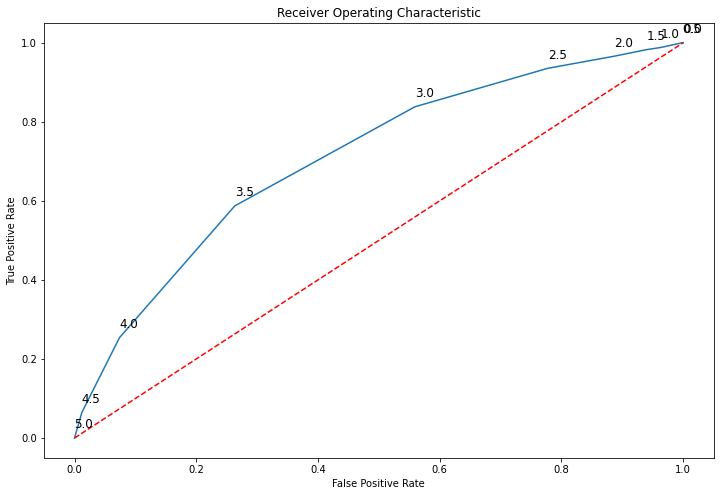

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
#plt.plot(fpr_list_test,tpr_list_test, 'b-x', linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy')
plt.plot(fpr_list_test,tpr_list_test)
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
thresholds = [0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
for index in range(len(thresholds)):
  ax.text(fpr_list_test[index], tpr_list_test[index]+0.025, thresholds[index], size=12)
plt.show()

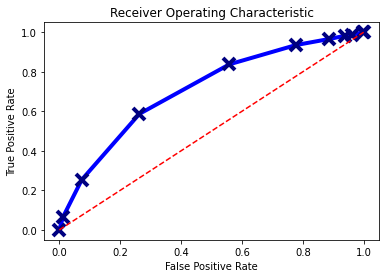

In [ ]:
plt.plot(fpr_list_test,tpr_list_test, 'b-x', linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy')
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
import numpy as np
tpr_list_test =[]
fpr_list_test=[]
def calculate_roc(threshold_passed):
  #print(threshold)
  #predictions_for_plot.show()
  #predictions_for_plot.where(col('user_affinity_predicted')==1).show()
  true_positive = predictions_for_plot.where((col('user_affinity')==1) & (col('user_affinity_predicted')==1)).count()
  false_positive = predictions_for_plot.where((col('user_affinity')==0) & (col('user_affinity_predicted')==1)).count()
  #print("The number of true positives is: " + str(true_positive))
  #print("The number of false positives is: " + str(false_positive))
  false_negative = predictions_for_plot.where((col('user_affinity')==1) & (col('user_affinity_predicted')==0)).count()
  true_negative = predictions_for_plot.where((col('user_affinity')==0) & (col('user_affinity_predicted')==0)).count()
  #print("The number of false negatives is: " + str(false_negative))
  #print("The number of true negatives is: " + str(true_negative))
  tpr = (true_positive)/(true_positive+false_negative)
  fpr = (false_positive)/(false_positive+true_negative)
  
  #print("The number of false negatives is: " + str(false_negative))
  #print("The precision is: "+str(precision))
  #print("The recall is: "+str(recall))
  tpr_list_test.append(tpr)
  fpr_list_test.append(fpr)
for threshold in np.arange(0, 5.5, 0.5):
  predictions_for_plot = predictions_for_plot.withColumn('user_affinity_predicted',when(col('user_predictions')>threshold,1).otherwise(0))
  calculate_roc(threshold)
  predictions_for_plot = predictions_for_plot.drop('user_affinity_predicted')
print(tpr_list_test)
print(fpr_list_test) 

[1.0, 0.9999075700157131, 0.9878784677749461, 0.9822798515838538, 0.9659989700658894, 0.9351141510305944, 0.837838194710364, 0.5871152601904057, 0.2538523497022434, 0.06474060185124055, 0.0]
[1.0, 0.9983275094824239, 0.9630558791028283, 0.9392527551294687, 0.8872263536720126, 0.7772302362392856, 0.559089687304005, 0.26326792700773527, 0.07385837589224382, 0.012065824448227458, 0.0]


In [ ]:
print(fpr_list_test)

[0.0]


In [ ]:
predictions_for_plot = predictions_for_plot.withColumn('user_predictions',when(predictions.prediction<=5.0,predictions.prediction).otherwise(5.0))

In [ ]:
recommendations_list = userSubsetRecs.first()['recommendations']

In [ ]:
recommendations_df = spark.createDataFrame(recommendations_list)

In [ ]:
recommendations_df.show()

+-----------------+------------------+
|business_id_index|            rating|
+-----------------+------------------+
|             4679| 4.558470726013184|
|             5758| 4.554303169250488|
|             5740| 4.552530288696289|
|             5401| 4.527248859405518|
|             3681|  4.46825647354126|
|             5266| 4.433201789855957|
|             4691| 4.400327682495117|
|             4163| 4.351329803466797|
|             5252|4.3509955406188965|
|             4998| 4.339371681213379|
+-----------------+------------------+



In [ ]:
recommended_business_df = recommendations_df.join(transformed,on="business_id_index",how="inner").select(col('business_id')).distinct()

In [ ]:
df_business_original = sqlContext.read.json('/content/drive/MyDrive/Big data/yelp_academic_dataset_business.json')

In [ ]:
recommended_restaurants = recommended_business_df.join(df_business_original,on="business_id",how="inner")

In [ ]:
recommended_restaurants.show()

+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|         business_id|             address|          attributes|          categories|        city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|tpmXakPzEw-Aapddj...|1043 Spring Garde...|{null, null, u'no...|Restaurants, Coff...|Philadelphia|{8:0-20:0, 8:0-20...|      0|    39.961974|   -75.1559599|   Teaful Bliss Cafe|      19123|          17|  5.0|   PA|
|xWCERoeAakW3OiA4D...|   4200 Manayunk Ave|{null, null, null...|Burgers, Delis, B...|Philadelphia|{9:0-12:0, 9:0-12...|      0|   40.0261995

# **Plotting the coordinates of the recommended restaurants using ALS on the Philadelphia map**

In [ ]:
import folium

PA_coordinates = [39.9525839, -75.1652215]

restaurant_map = folium.Map(location = PA_coordinates, zoom_start = 12) 

# Converting spark dataframe to Pandas df for plotting
keyword_df =  recommended_restaurants.select('name', 'stars', 'review_count', 'latitude', 'longitude').toPandas()

# add marker one by one on the map
for i in range(0,len(keyword_df)):
    folium.Marker(
                  location=[keyword_df.iloc[i]['latitude'], keyword_df.iloc[i]['longitude']],
                  popup=keyword_df.iloc[i]['name'] + '\n' + \
                        'Rating: ' + str(keyword_df.iloc[i]['stars']) + '\n' + \
                        'Reviews: ' + str(keyword_df.iloc[i]['review_count']), \
                  icon=folium.Icon(color='red')
                  ).add_to(restaurant_map)

# Show the map again
restaurant_map

# **Plotting the coordinates of the recommended restaurants using Cosine Similarity on the Philadelphia map**

In [ ]:
#Cosine Similarity Recommendations
import folium

PA_coordinates = [39.9525839, -75.1652215]

restaurant_map = folium.Map(location = PA_coordinates, zoom_start = 12) 

# Converting spark dataframe to Pandas df for plotting
keyword_df =  similar_restuarants_details.select('name', 'stars_restaurant', 'review_count', 'latitude', 'longitude').toPandas()

# add marker one by one on the map
for i in range(0,len(keyword_df)):
    folium.Marker(
                  location=[keyword_df.iloc[i]['latitude'], keyword_df.iloc[i]['longitude']],
                  popup=keyword_df.iloc[i]['name'] + '\n' + \
                        'Rating: ' + str(keyword_df.iloc[i]['stars_restaurant']) + '\n' + \
                        'Reviews: ' + str(keyword_df.iloc[i]['review_count']), \
                  icon=folium.Icon(color='red')
                  ).add_to(restaurant_map)

# Show the map again
restaurant_map

# **Change in Root mean square error with change in Maxiterations for gradient descent,Regularization parameter combination**

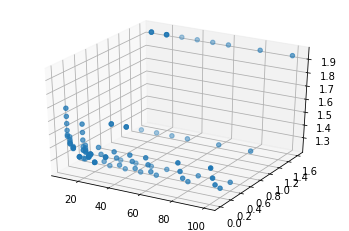

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
ax = plt.axes(projection = '3d')
#x = [20,30,40,50,60,70,20,30,40,50,60,70,40,40,40,40,40,40,20,30,40,50,60,70,20,30,40,50,60,70,40,40,40,40,40,40,20,30,40,50,60,70,20,30,40,50,60,70,40,40,40,40,40,40,20,30,40,50,60,70,20,30,40,50,60,70,40,40,40,40,40,40,4,4,3,3,4,4,3,3,10,20,30,40,50,60,70,20,30,40,50,60,70,40,40,40,40,40,40,20,30,40,50,60,70,20,30,40,50,60,70,40,40,40,40,40,40,20,30,40,50,60,70,20,30,40,50,60,70,40,40,40,40,40,40]
x = [10,10,10,10,10,10,20,20,20,20,20,20,30,40,50,60,80,100,10,10,10,10,10,10,20,20,20,20,20,20,30,40,50,60,80,100,10,10,10,10,10,10,20,20,20,20,20,20,30,40,50,60,80,100,10,10,10,10,10,10,20,20,20,20,20,20,30,40,50,60,80,100,10,9,10,9,10,9,10,9,10,10,10,10,10,10,10,20,20,20,20,20,20,30,40,50,60,80,100,10,10,10,10,10,10,20,20,20,20,20,20,30,40,50,60,80,100,10,10,10,10,10,10,20,20,20,20,20,20,30,40,50,60,80,100]
y = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.3,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6]
z = [1.690830124,1.630591751,1.576397955,1.525511926,1.491531589,1.480939978,1.595453763,1.532830083,1.475383133,1.425081135,1.400218645,1.396614645,1.443112951,1.433463213,1.432957384,1.43650904,1.447331577,1.458048749,1.46726482,1.446402211,1.432114176,1.420415362,1.415653227,1.412175372,1.42708644,1.407066213,1.3917857,1.383390872,1.377364158,1.372781262,1.381047297,1.37684898,1.374987105,1.373928551,1.372890091,1.372611501,1.381934258,1.376009405,1.370976545,1.369394454,1.367734245,1.364817797,1.335237828,1.329680717,1.325984381,1.324726316,1.323750058,1.321957409,1.313970697,1.310136357,1.308923065,1.308579538,1.308731181,1.309018238,1.279151003,1.276265594,1.277859706,1.276949382,1.277322098,1.277262241,1.261130089,1.258076869,1.258638759,1.25797445,1.257844046,1.25776093,1.257013462,1.257165025,1.257432572,1.257634611,1.257915983,1.25811897,1.241097965,1.24108162,1.236168646,1.235509158,1.247442304,1.246720733,1.244661662,1.24370359,1.249215144,1.250864934,1.25029329,1.25085218,1.250609883,1.250788472,1.251044795,1.25161762,1.251047101,1.251512258,1.25110381,1.251291774,1.25146604,1.252130071,1.252425327,1.252586766,1.252696421,1.252853588,1.252953962,1.395535364,1.395536557,1.395558357,1.39556657,1.395575629,1.395584848,1.395138671,1.395150341,1.395153978,1.395158631,1.395169436,1.395175403,1.395117792,1.395112144,1.395111967,1.395112943,1.39511586,1.395118234,1.935953118,1.935949342,1.935956723,1.93596634,1.935963601,1.935967581,1.935827135,1.935829382,1.935832077,1.935840031,1.93583931,1.935842055,1.935816642,1.935810207,1.935806747,1.935804627,1.93580221,1.935800935]
#ax.plot(x,y,z)
ax.scatter(x,y,z)
plt.show()

# **Regularization parameter VS RMSE**

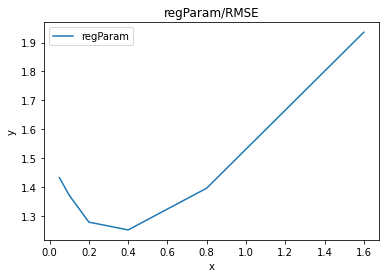

In [ ]:
import matplotlib.pyplot as plt

def found_fit(x):
    return 0.388 * x**2  # Found with symfit.

x_data = [0.05,0.1,0.2,0.4,0.8,1.6]
y_data = [1.43211417617252, 1.37097654482398, 1.27785970588377, 1.25085217978433, 1.39555835680421, 1.9359567229799]
plt.plot(x_data, y_data, label='regParam')
plt.xlabel('x')
plt.ylabel('y')
plt.title('regParam/RMSE')
plt.legend()
plt.show()

# **Maxiters for Gradient Descent VS RMSE**

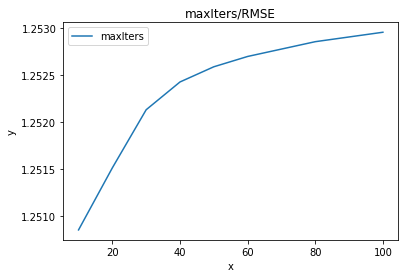

In [ ]:
import matplotlib.pyplot as plt

def found_fit(x):
    return 0.388 * x**2  # Found with symfit.

x_data = [10,20,30,40,50,60,80,100]
y_data = [1.25085217978433,1.251512257527,1.25213007113353,1.25242532748511,1.25258676580865,1.25269642077722,1.2528535876819,1.2529539617649]
plt.plot(x_data, y_data, label='maxIters')
plt.xlabel('x')
plt.ylabel('y')
plt.title('maxIters/RMSE')
plt.legend()
plt.show()

# **Number of Features VS RMSE**

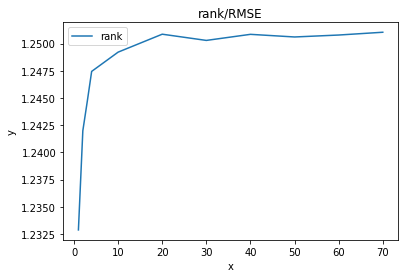

In [ ]:
import matplotlib.pyplot as plt

def found_fit(x):
    return 0.388 * x**2  # Found with symfit.

x_data = [1,2,3,4,10,20,30,40,50,60,70]
y_data = [1.23286286025879,1.24198383835273,1.2446618707356,1.24744238255052,1.24921514382086,1.2508649336001,1.25029328982081,1.25085217978433,1.25060988324865,1.25078847214564,1.25104479527911]
plt.plot(x_data, y_data, label='rank')
plt.xlabel('x')
plt.ylabel('y')
plt.title('rank/RMSE')
plt.legend()
plt.show()

# **Top 10 trending restaurants that are nearby a user, based on the coordinates and restaurant rating. Using PYMongo's  GEO2D package to achieve this**

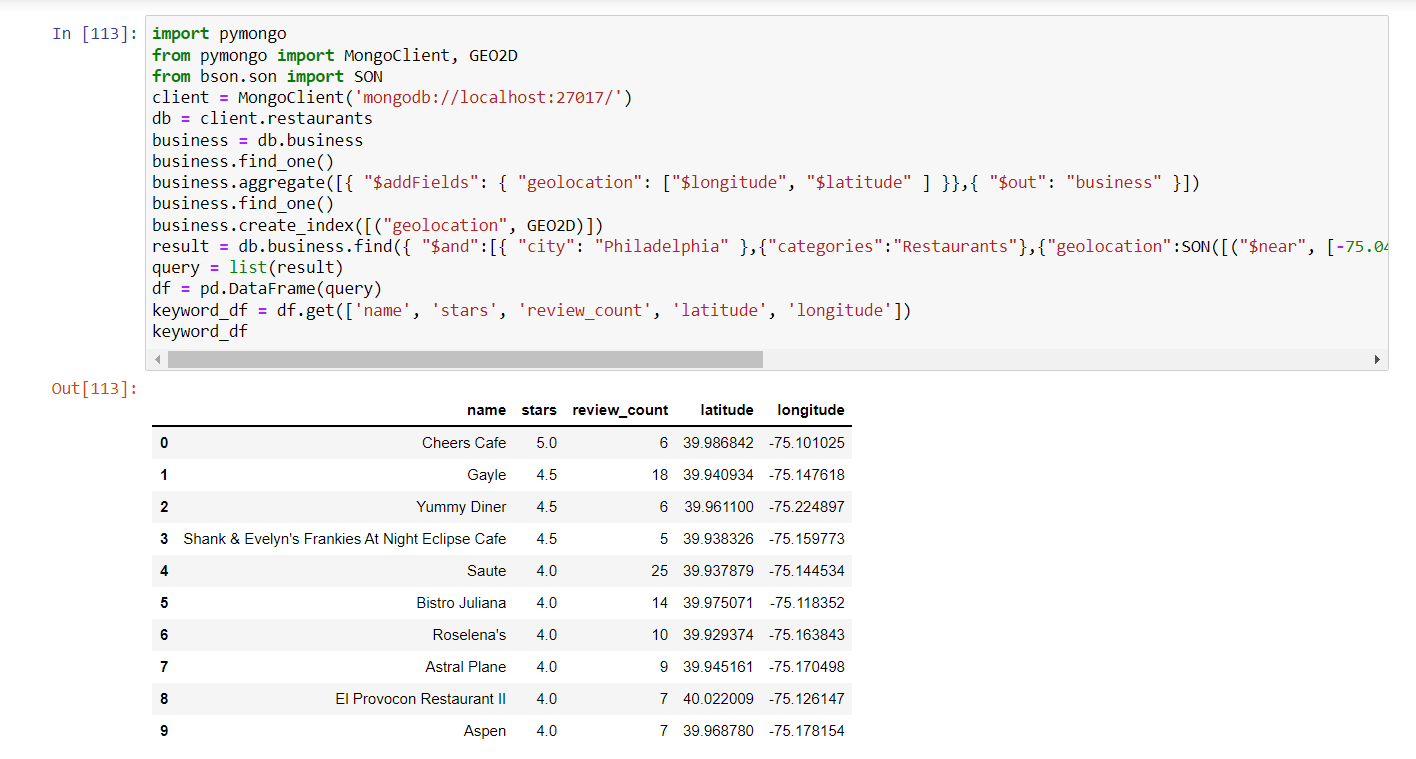

# **Plotting the top 10 trending restaurants onto the map**

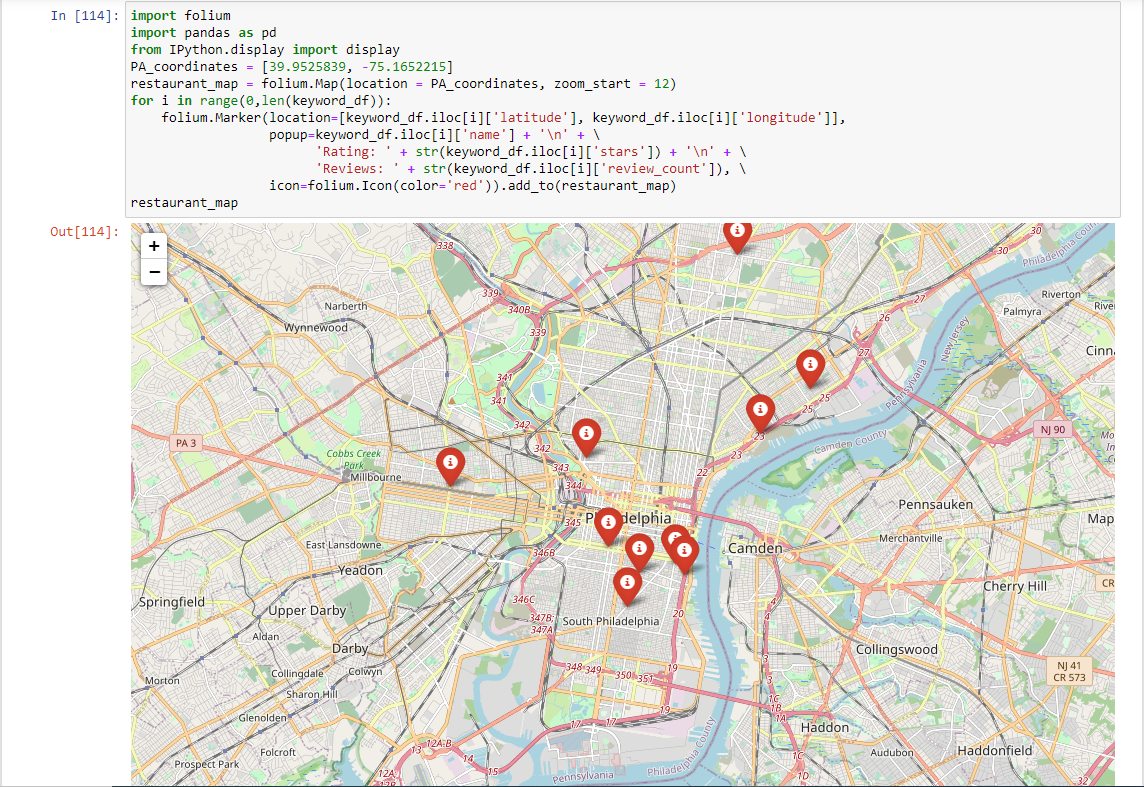